In [49]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull

In [50]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [51]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/output_repar_03-01/'               # Harmon server
name_project

'project_repartition_v3.0/output_repar_01-02/'

In [52]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-02/


In [53]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [54]:
name_project_probes = info_basic['name_project_probes']
name_project_targets = info_basic['name_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, name_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, name_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/
dir_project_targets:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-02/


In [55]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

In [56]:
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']

In [57]:
dir_image = dir_project+info_basic['dir_image']
dir_disp_probes  = dir_project_probes + info_basic_probes['dir_disp'] 
print('dir_image: ', dir_image)
print('dir_disp: ', dir_disp_probes)

dir_image:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-02/image_01-02/
dir_disp:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/autopick17-01//


In [58]:
stalistname_all = info_basic_probes['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_all =  stainfo['latitude'].tolist() 
lon_all =  stainfo['longitude'].tolist() 

In [59]:
stalistname = dir_project_probes + info_basic_probes['stalistname']
stainfo_all = pd.read_excel(stalistname,sheet_name=None)

In [60]:
locinfo = pd.read_excel(dir_project_probes + 'subwork_location.xlsx',sheet_name='location')

### Plot to see pick results

In [61]:
flag_plot = 0
flag_f = [10,15]

In [62]:
if flag_plot == 1:
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    for probe in probes:
        f_pick = np.loadtxt(dir_disp_probes+'autopick_'+probe+'.txt',delimiter=',')[:,0]
        c_pick = np.loadtxt(dir_disp_probes+'autopick_'+probe+'.txt',delimiter=',')[:,1]
        ax.scatter(f_pick,c_pick,marker='o',s=10)
    ax.set_ylim([0.2,2])
    ax.set_xlim(flag_f)

### phase plot

In [63]:
f_ranges = {}
f_ranges[1] = [7,8]
f_ranges[2] = [8,9]
f_ranges[3] = [9,11]
f_ranges[4] = [11,15]

In [64]:
lat_this = []
lon_this = []
for probe in probes:
    lon_this.append(locinfo['lon_centroid'][probes.index(probe)])
    lat_this.append(locinfo['lat_centroid'][probes.index(probe)])

In [65]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [66]:
phase = {}
for f_range in f_ranges.keys():
    phase[f_range] = []
for probe in probes:
    disp = np.loadtxt(dir_disp_probes+'autopick_'+probe+'.txt',delimiter=',')
    f_pick = disp[:,0]
    c_pick = disp[:,1]
    for f_range in f_ranges.keys():
        f_start = f_ranges[f_range][0]
        f_end = f_ranges[f_range][1]
        index = np.where((f_pick>=f_start) & (f_pick<f_end))[0]
        c_mean = np.mean(c_pick[index])
        phase[f_range].append(c_mean)

/home/songsh/anaconda3/envs/ccfj/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/songsh/anaconda3/envs/ccfj/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


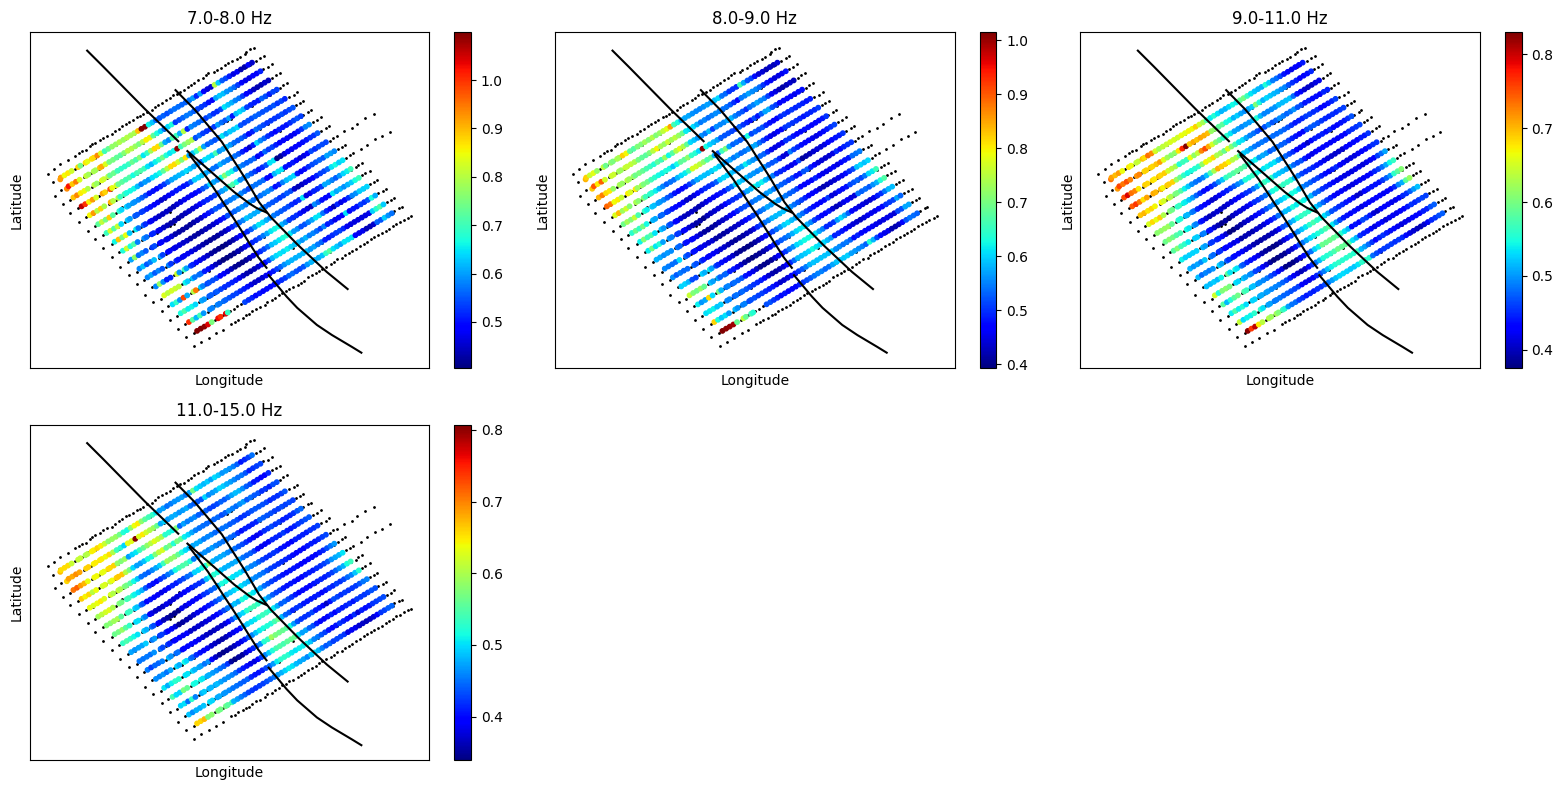

In [67]:
fig = plt.figure(figsize=(16,8))
flag_num = 1
row_num = 2
col_num = 3
for f_range in f_ranges.keys():
    ax = plt.subplot(row_num,col_num,flag_num)
    ax.scatter(lon_all,lat_all,c='k',s=1)
    im = ax.scatter(lon_this,lat_this,c=phase[f_range],cmap='jet',s=10)
    ax.set_title('%.1f-%.1f Hz'%(f_ranges[f_range][0],f_ranges[f_range][1]))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
    flag_num += 1
    fig.colorbar(im, ax=ax)
plt.tight_layout()

### Set phase range and calculate mean value

In [68]:
ks_f_range = [7.5,11]
info_basic['ks_f_range'] = ks_f_range

In [69]:
phase_this = {}
for probe in probes:
    disp = np.loadtxt(dir_disp_probes+'autopick_'+probe+'.txt',delimiter=',')
    f_pick = disp[:,0]
    c_pick = disp[:,1]
    f_start = ks_f_range[0]
    f_end = ks_f_range[1]
    index = np.where((f_pick>=f_start) & (f_pick<f_end))[0]
    c_mean = np.mean(c_pick[index])
    phase_this[probe] = c_mean

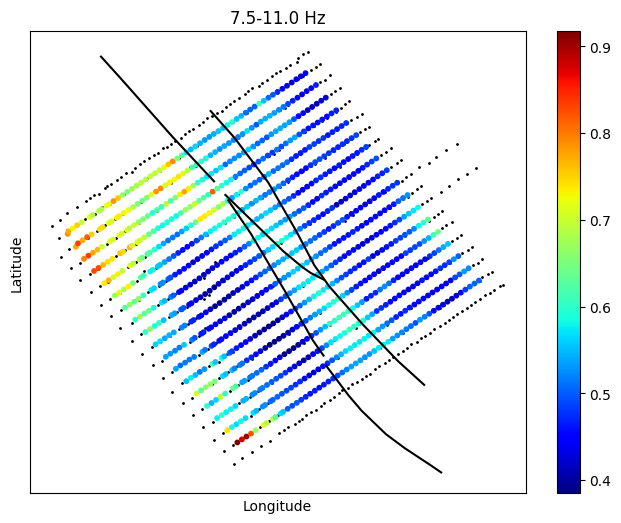

In [70]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(lon_all,lat_all,c='k',s=1)
im = ax.scatter(lon_this,lat_this,c=[phase_this[probe] for probe in probes],cmap='jet',s=10)
ax.set_title('%.1f-%.1f Hz'%(ks_f_range[0],ks_f_range[1]))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xticks([])
ax.set_yticks([])
for i in range(len(faults)):
    ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
flag_num += 1
fig.colorbar(im, ax=ax)

In [71]:
info_basic_bi['phase_mean'] = phase_this

In [72]:
np.save(dir_project + 'Basic_info.npy', info_basic_bi)
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)